## Coursework 2: Judging a book by its synopsis

Final modelling scenario whereby I am utilzing a pre-trained embedding available from the TensorFlow Hub and code created by AIEngineering [online] available at https://www.youtube.com/watch?v=dkpS2g4K08s. This code csreate an end to end NLP pipeline starting from cleaning text data, setting NLP pipeline, model selection and model evaluation while handling handling imbalanced a dataset.

basic application of transfer learning with TensorFlow Hub and Keras.

## A. Set up packages & import data

In [458]:
import pandas as pd
import numpy as np   
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

## B. Further exploratory data analysis

Further study since the completion of CW1 has drawn my attention to the need to review some aspects of my dataset pipelone, namely reviewing the length of the synopses for optimal feature building and the need for rebalancing the number of cases ahead of model build.

## C. Using a Bag of Words weighting approach to categorise books

In [ ]:
# Outline of work (refer to 'https://towardsdatascience.com/text-classification-in-python-dd95d264c802' for good reasoning on 
# required steps)

# 1. Prepare the data - target to integer, split into training and test
# 2. Feature design
# 3. Model build
# 4. Evaluation

### 1. Prepare data

In [391]:
########## i. Import finalised data from CW1 ##########

# The steps for data extraction and preprocessing were undertaken in CW1
# Keep finalised synopsis and target (='Subject')
df=pd.read_csv(r"C:\Users\jmd05\DSM-020\4. CW1\Data\all1.csv", index_col=0, usecols=['Synopsis2','Subject']).reset_index()
#df.shape #656, 2

In [392]:
# Review the data
df.head()

,Subject,Synopsis2
0,sports leisure,"['first', 'time', 'world', 'renowned', 'revolu..."
1,sports leisure,"['pat', 'nevin', 'never', 'want', 'professiona..."
2,sports leisure,"['one', 'man', 'seventeen', 'year', 'old', 'sa..."
3,sports leisure,"['two', 'comedy', 'greats', 'talk', 'life', 'f..."
4,sports leisure,"['sign', 'edition', 'standard', 'edition', 'av..."


In [393]:
########## ii. Target to integer ##########

# Use LabelEncoder to transform categorical labels to interger labels
encoder=preprocessing.LabelEncoder()
encoder.fit(df.Subject)
df['Subject1']=encoder.transform(df.Subject)

#df.groupby(['Subject','Subject1'])['Subject1'].count()

# Get this encoding:
# Subject                      Subject1
# business finance law         0           70
# entertainment                1           79
# food drink                   2           88
# history                      3           91
# romantic fiction             4           92
# science technology medicine  5           72
# spirituality beliefs         6           75
# sports leisure               7           89

In [460]:
########## iii. Create class weights ##########

class_weights=list(class_weight.compute_class_weight('balanced', np.unique(df['Subject']), df['Subject']))
class_weights.sort()
weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
weights

{0: 0.8913043478260869,
 1: 0.9010989010989011,
 2: 0.9213483146067416,
 3: 0.9318181818181818,
 4: 1.0379746835443038,
 5: 1.0933333333333333,
 6: 1.1388888888888888,
 7: 1.1714285714285715}

In [395]:
########## iv. Split data into training & validation ##########

# Decided dataset is too small for a hold out (the accuracy results were poor) so just create train and validation and 
# restrict size of validation to 20% of all cases
train, valid = train_test_split(df, test_size=0.20, random_state=42)
#train.shape # 524, 3
#valid.shape # 132, 3

### 2. TF-IDF feature creation

In [436]:
# Code approach adapted from article 'Text Classification in Python' [online] available at:
# Article: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
# Code: http://localhost:8888/notebooks/DSM-020/5.%20CW2/GitHub-Repo/Third%20party%20code%20reference/03.%20Feature%20Engineering.ipynb

# Initial parameter selections for TfidfVectorizer
ngram_range = (1,2) # Range of n-grams to be used in feature creation e.g. (1,3) = 1-,2- & 3-grams are created
min_df = 5          # Ignore terms that have a document frequency strictly lower than nominal value X
max_df = 1.0        # Ignore terms that have a document frequency strictly higher than X%
max_features = 1000 # Use the top X features based on frequency count across all books

# Note that the default setting in this function skips the tokenisation process as data is already tokenised
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True)
# Admission: I do not know what 'sublinear_tf' contributes as a parameter but note that it adds a 2 percentage point 
# increase in accuracy

In [437]:
# Transform the training and test data into TF-IDF weights
train_t = tfidf.fit_transform(train['Synopsis2']).toarray()
valid_t  = tfidf.transform(valid['Synopsis2']).toarray()
#train_t.shape # 524, 300
#valid_t.shape # 132, 300

In [ ]:
# TO DO: 
# Use the Chi squared test in order to see what unigrams and bigrams are most correlated with each subject
# Do this using code at bottom of 
# http://localhost:8888/notebooks/DSM-020/5.%20CW2/GitHub-Repo/Third%20party%20code%20reference/03.%20Feature%20Engineering.ipynb

### 3. Build a classification model using the TF-IDF features

Why choose SVM?

Advantages
SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm. They also use less 
memory because they use a subset of training points in the decision phase. SVM works well with a clear margin of separation 
and with high dimensional space.

Disadvantages
SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to 
Naïve Bayes. It works poorly with overlapping classes and is also sensitive to the type of kernel used.

#### i. Build a base model

I took guidance on how to build a model from DataCamp article 'Support Vector Machines with Scikit-learn'[online] found at:
https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [552]:
def base_model(wgts=None):
    # Create a Support Vector Machine classifier instance using a 'linear' kernal and balanced data
    model=svm.SVC(kernel='linear', class_weight=wgts)
    # Train the model using the transformed TF-IDF training data
    model.fit(train_t, train['Subject1'])
    # Predict the subject categories for validation datasets
    valid_pred = model.predict(valid_t)
    # Calculate model accuracy on the validation data
    class_accuracy=metrics.accuracy_score(valid['Subject1'], valid_pred)
    return valid_pred, class_accuracy

In [553]:
valid_pred, class_accuracy=base_model(weights)
valid_pred1, class_accuracy1=base_model(None)
print('Balanced accuracy=',class_accuracy)
print('Unbalanced accuracy=',class_accuracy1)
# Using weights to balance the data makes no difference on performance, in fact it reduces performance, so consider the 
# unbalanced data going forward

Balanced accuracy= 0.6893939393939394
Unbalanced accuracy= 0.696969696969697


Unbalanced - validation accuracy: 0.696969696969697

Unbalanced - classification report:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.68      0.68      0.68        22
           2       1.00      0.93      0.96        14
           3       0.58      0.88      0.70        17
           4       0.79      0.79      0.79        19
           5       0.31      0.67      0.42         6
           6       0.70      0.44      0.54        16
           7       1.00      0.65      0.79        26

    accuracy                           0.70       132
   macro avg       0.69      0.69      0.67       132
weighted avg       0.75      0.70      0.70       132


Unbalanced - classification matrix:


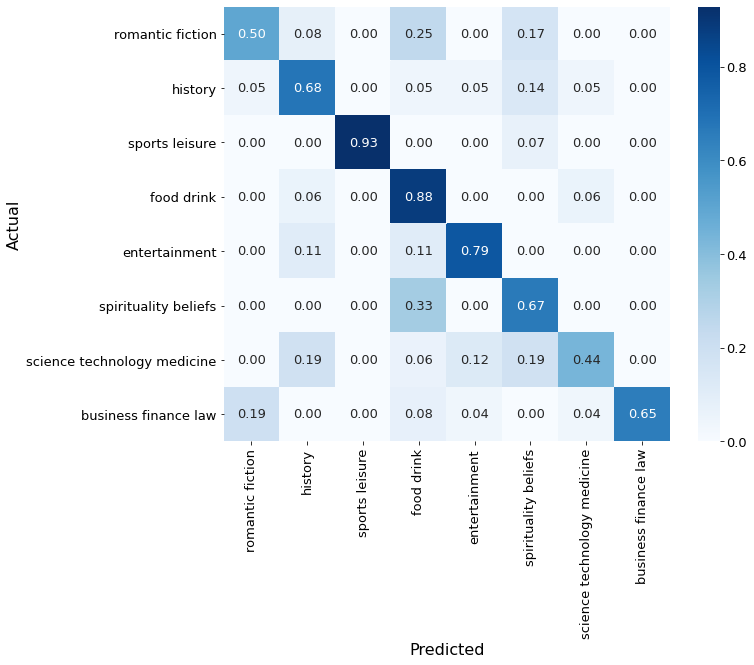

In [556]:
# Evaluate the unbalanced model

# Metrics used:
# Accuracy: the accuracy metric measures the ratio of correct predictions over the total number of instances evaluated.
# Precision: precision is used to measure the positive patterns that are correctly predicted from the total predicted patterns 
#            in a positive class.
# Recall: recall is used to measure the fraction of positive patterns that are correctly classified
# F1-Score: this metric represents the harmonic mean between recall and precision values

# Overall accuracy
print("\033[1m"+"Unbalanced - validation accuracy:"+"\033[0m",metrics.accuracy_score(valid['Subject1'], valid_pred1))
print()

# Other metrics
print("\033[1m"+"Unbalanced - classification report:"+"\033[0m")
print()
print(classification_report(valid['Subject1'], valid_pred1))
print()

# Classification matrix
def class_matrix(act, pred, labels):
    # Create the subject assignment breakdown
    cm = confusion_matrix(act, pred)
    # Convert assignment counts into assignment percentages of each subject (calculate across the rows)
    cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots(figsize=(10,8))
    plt.rcParams.update({'font.size': 13})
    sns.heatmap(cmp, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual', size=16)
    plt.xlabel('Predicted', size=16)
    return plt.show(block=False)

subjects=['romantic fiction',
          'history',
          'sports leisure',
          'food drink',
          'entertainment',
          'spirituality beliefs',
          'science technology medicine',
          'business finance law']

print("\033[1m"+"Unbalanced - classification matrix:"+"\033[0m"),
class_matrix(valid['Subject1'],valid_pred1, subjects)

##### ii. Optimise the model by tuning hyperparameters

I learned how to tune a model from the article 'SVM Hyperparameter Tuning using GridSearchCV | ML'[online] found at: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [559]:
# SVM has 3 parameters which can be tuned to optimise model build - kernal & regularization & gamma

# Create a parameter grid
grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': [.0001, .001, .01, .1, 1, 10, 100]}
print(grid)

{'C': [0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}


In [560]:
# Instantiate the model using GridSearch
model1 = GridSearchCV(SVC(), grid, refit = True, verbose = 3)
  
# Fit the model to unbalanced traing data
model1.fit(train_t, train['Subject1'])

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] C=0.01, gamma=0.0001, kernel=linear .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.01, gamma=0.0001, kernel=linear, score=0.133, total=   0.5s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] . C=0.01, gamma=0.0001, kernel=linear, score=0.133, total=   0.5s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] . C=0.01, gamma=0.0001, kernel=linear, score=0.267, total=   0.5s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] . C=0.01, gamma=0.0001, kernel=linear, score=0.257, total=   0.5s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] . C=0.01, gamma=0.0001, kernel=linear, score=0.375, total=   0.5s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .... C=0.01, gamma=0.0001, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .... C=0.01, gamma=0.0001, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .... C=0.01, gamma=0.0001, kernel=rbf, score=0.267, total=   0.4s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .... C=0.01, gamma=0.0001, kernel=rbf, score=0.257, total=   0.4s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .

[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.133, total=   0.4s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.133, total=   0.4s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.267, total=   0.4s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.257, total=   0.4s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.375, total=   0.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.01, gamma=1, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ......... C=0.01, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] .

[CV] .... C=0.1, gamma=0.0001, kernel=poly, score=0.257, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .... C=0.1, gamma=0.0001, kernel=poly, score=0.231, total=   0.5s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.238, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.276, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.267, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.257, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.375, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.133, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.248, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.257, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.231, total=   0.4s
[CV] C=0.1, gamma=10, kernel=linear ..................................
[CV] ...... C=0.1, gamma=10, kernel=linear, score=0.238, total=   0.4s
[CV] C=0.1, gamma=10, kernel=linear ..................................
[CV] ...... C=0.1, gamma=10, kernel=linear, score=0.276, total=   0.4s
[CV] C=0.1, gamma=10, kernel=linear ..................................
[CV] ...... C=0.1, gamma=10, kernel=linear, score=0.267, total=   0.5s
[CV] C=0.1, gamma=10, kernel=linear ..................................
[CV] .

[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.375, total=   0.4s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.133, total=   0.4s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.133, total=   0.4s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.248, total=   0.4s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.257, total=   0.4s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.231, total=   0.4s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.667, total=   0.4s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] .

[CV] ........... C=1, gamma=10, kernel=rbf, score=0.143, total=   0.4s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] ........... C=1, gamma=10, kernel=rbf, score=0.190, total=   0.4s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] ........... C=1, gamma=10, kernel=rbf, score=0.183, total=   0.4s
[CV] C=1, gamma=10, kernel=poly ......................................
[CV] .......... C=1, gamma=10, kernel=poly, score=0.438, total=   0.4s
[CV] C=1, gamma=10, kernel=poly ......................................
[CV] .......... C=1, gamma=10, kernel=poly, score=0.419, total=   0.4s
[CV] C=1, gamma=10, kernel=poly ......................................
[CV] .......... C=1, gamma=10, kernel=poly, score=0.343, total=   0.4s
[CV] C=1, gamma=10, kernel=poly ......................................
[CV] .......... C=1, gamma=10, kernel=poly, score=0.448, total=   0.4s
[CV] C=1, gamma=10, kernel=poly ......................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.352, total=   0.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.381, total=   0.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.343, total=   0.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.390, total=   0.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.394, total=   0.4s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] ....... C=10, gamma=0.01, kernel=poly, score=0.133, total=   0.4s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] ....... C=10, gamma=0.01, kernel=poly, score=0.133, total=   0.4s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .

[CV] ...... C=10, gamma=100, kernel=linear, score=0.705, total=   0.4s
[CV] C=10, gamma=100, kernel=linear ..................................
[CV] ...... C=10, gamma=100, kernel=linear, score=0.683, total=   0.4s
[CV] C=10, gamma=100, kernel=rbf .....................................
[CV] ......... C=10, gamma=100, kernel=rbf, score=0.133, total=   0.4s
[CV] C=10, gamma=100, kernel=rbf .....................................
[CV] ......... C=10, gamma=100, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, gamma=100, kernel=rbf .....................................
[CV] ......... C=10, gamma=100, kernel=rbf, score=0.143, total=   0.5s
[CV] C=10, gamma=100, kernel=rbf .....................................
[CV] ......... C=10, gamma=100, kernel=rbf, score=0.143, total=   0.4s
[CV] C=10, gamma=100, kernel=rbf .....................................
[CV] ......... C=10, gamma=100, kernel=rbf, score=0.163, total=   0.5s
[CV] C=10, gamma=100, kernel=poly ....................................
[CV] .

[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.714, total=   0.4s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.648, total=   0.4s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.695, total=   0.5s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.654, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.648, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.705, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.648, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ....... C=100, gamma=100, kernel=poly, score=0.442, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.629, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.714, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.648, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.695, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.654, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.362, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .

[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.305, total=   0.4s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.438, total=   0.4s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.423, total=   0.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.629, total=   0.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.714, total=   0.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.648, total=   0.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.695, total=   0.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  4.4min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [563]:
# Classify books of validation data with optimised parameters
#print(model1.best_params_)
# {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
valid_pred2 = model1.predict(valid_t)

Unbalanced - tuned - validation accuracy: 0.7121212121212122

Unbalanced - tuned - classification report:

              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.83      0.68      0.75        22
           2       1.00      0.86      0.92        14
           3       0.61      1.00      0.76        17
           4       0.78      0.95      0.86        19
           5       0.27      0.67      0.38         6
           6       0.78      0.44      0.56        16
           7       1.00      0.62      0.76        26

    accuracy                           0.71       132
   macro avg       0.72      0.70      0.68       132
weighted avg       0.78      0.71      0.72       132


Unbalanced - tuned - classification matrix:


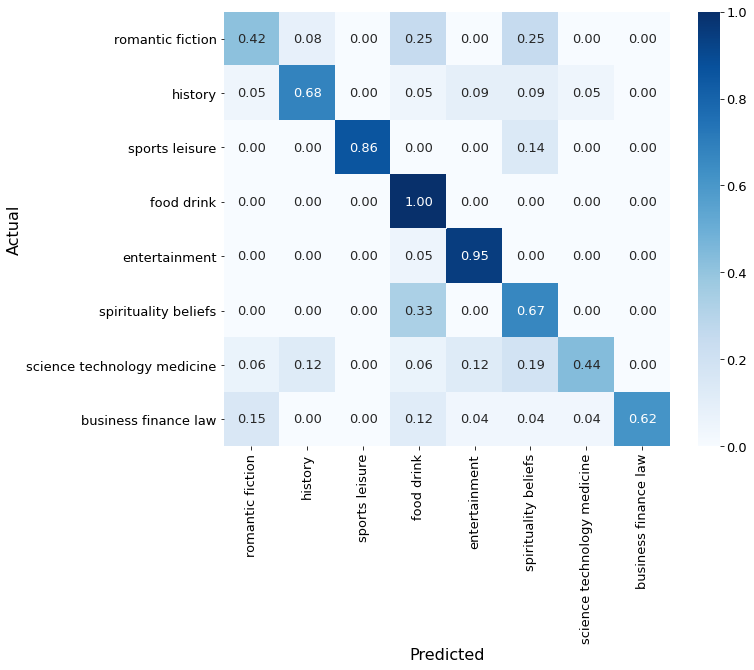

In [564]:
# Evaluate the unbalanced & tuned model

# Overall accuracy
print("\033[1m"+"Unbalanced - tuned - validation accuracy:"+"\033[0m",metrics.accuracy_score(valid['Subject1'], valid_pred2))
print()
# Other metrics
print("\033[1m"+"Unbalanced - tuned - classification report:"+"\033[0m")
print()
print(classification_report(valid['Subject1'], valid_pred2))
print()
# Confusion matrix
print("\033[1m"+"Unbalanced - tuned - classification matrix:"+"\033[0m"),
class_matrix(valid['Subject1'],valid_pred2,subjects)

# Overall accuracy improves by 0.4 percentage points.
# The accuracies of each subject changed from the untuned model with some subjects decreasing in accuracy while others improved

In [ ]:
###########################
# Get top n-grams & chart #
###########################

## D. Using a pre-trained embedding from the TensorFlow Hub to categorise books

Final modelling scenario whereby I am utilzing a pre-trained embedding available from the TensorFlow Hub and code created by AIEngineering [online] available at https://www.youtube.com/watch?v=dkpS2g4K08s. This code csreate an end to end NLP pipeline starting from cleaning text data, setting NLP pipeline, model selection and model evaluation while handling handling imbalanced a dataset.

basic application of transfer learning with TensorFlow Hub and Keras.

### 1. TensorFlow environment

In [168]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


### 2. Data preprocessing

In [169]:
#################### a. Import finalised data from CW1 ####################

# Keep the original unprocessed text and target (='Subject')
df=pd.read_csv(r"C:\Users\jmd05\DSM-020\4. CW1\Data\all1.csv", index_col=0, usecols=['Synopsis','Subject']).reset_index()
#df.shape #656, 2

In [170]:
#################### b. Create a dictionary comprising re-balancing weights for each target class ####################

class_weights=list(class_weight.compute_class_weight('balanced', np.unique(df['Subject']), df['Subject']))
class_weights.sort()
weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
weights

{0: 0.8913043478260869,
 1: 0.9010989010989011,
 2: 0.9213483146067416,
 3: 0.9318181818181818,
 4: 1.0379746835443038,
 5: 1.0933333333333333,
 6: 1.1388888888888888,
 7: 1.1714285714285715}

In [171]:
##################### c. Create the required subsets of data of model build and evaluations ####################

# This function was written by Stackoverflow user piRSquared at 
# https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
# def train_validate_test_split(df, train_percent=.5, validate_percent=.25, seed=None):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

# train_data, validation_data, test_data = train_validate_test_split(df)

# Decided dataset is too small for a hold out (the accuracy results were poor) so just use train and validation
train, valid = train_test_split(df, test_size=0.30, random_state=42)

In [39]:
#train.shape      # 459
#valid.shape      # 197

In [173]:
##################### d. Create Tensor slices #####################

train1 = tf.data.Dataset.from_tensor_slices((train['Synopsis'].values, train['Subject'].values))
valid1 = tf.data.Dataset.from_tensor_slices((valid['Synopsis'].values, valid['Subject'].values))
#test = tf.data.Dataset.from_tensor_slices((test_data['Synopsis'].values, test_data['Subject'].values))

In [174]:
# Review an example of tensor data - the synopses have not been processed in any way

train_example_synopsis, train_example_subject = next(iter(train1.batch(1)))
print(train_example_synopsis, train_example_subject)

tf.Tensor([b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and more holloway proves an empathic

In [175]:
##################### e. One hot encode the categorical target labels for NN processing #####################

# Note this section of code was adapted from that created by AIEngineering found online at 
# https://www.youtube.com/watch?v=dkpS2g4K08s

# Create a immutable look-up table that can be referred to in one hot encoding (OHE) process
table = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(
                                  keys=tf.constant(['romantic fiction','history','sports leisure','food drink','entertainment',
                                                    'spirituality beliefs','science technology medicine',
                                                    'business finance law']), 
                                  values=tf.constant([0,1,2,3,4,5,6,7])),
                                  default_value=tf.constant(-1),
                                  name="target_encoding")

@tf.function
def target(x):
  return table.lookup(x)

# Define OHE function to transform the lable's 1-d representation to an 8-d array representation 
# (8 being the number of unique labels)
def fetch(text, labels):
  return text, tf.one_hot(target(labels),8)

# Undertake OHE on each element in the tensor slides
train2=train1.map(fetch)
valid2=valid1.map(fetch)
#test1=test.map(fetch)

In [176]:
# Review example of a transformed target label
next(iter(train2))

(<tf.Tensor: shape=(), dtype=string, numpy=b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and 

### 3. Model build

In [177]:
#################### a. Create a Keras layer that uses a TensorFlow Hub model to embed the sentences ####################

##############################################################################
# TO DO: RIGHT A TRY EXCEPT STATEMENT FOR IMPORTING THE EMBEDDING LINK BELOW #
##############################################################################

#embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
embedding = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                          dtype=tf.string, trainable=True)

#embedding = "https://tfhub.dev/google/nnlm-en-dim128/1"
# embedding = "https://tfhub.dev/google/nnlm-zh-dim128-with-normalization/2"
# hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], 
#                            dtype=tf.string, trainable=True)

# Review the embeddings for the example above
hub_layer(train_example_synopsis)

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.15719491, -0.1995717 ,  0.24811843,  0.14680661, -0.4304029 ,
        -0.42705414, -0.81705767, -0.37310374, -0.84438545,  0.08288607,
        -0.10753941,  0.06627724, -0.06985325, -0.13207957,  0.20052053,
        -0.38404042, -0.24509044, -0.70608956,  0.31535238, -0.40940908,
        -0.00983365, -0.03260244,  1.3918756 , -0.01981452, -0.65770364,
         0.6233454 , -0.72337645, -0.26033735,  0.5417876 , -0.9557794 ,
        -0.13185675,  0.34277746,  0.44721085,  0.08461031, -1.093546  ,
        -0.20781052,  0.02075935,  0.08639432, -0.07590501, -1.1476374 ,
         0.59333414,  0.12367294, -0.5802365 ,  0.41011825,  0.09539206,
        -0.40901104,  0.37202957,  0.52231544,  0.4361763 , -0.0992899 ]],
      dtype=float32)>

In [178]:
#################### b. Build full model ####################

model = tf.keras.Sequential()
model.add(hub_layer)
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

# Review model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
Total params: 48,191,552
Trainable params: 48,191,552
Non-trainable params: 0
_________________________________________________________________


In [179]:
#################### c. Compile the model ####################

# Set up Tensor board history
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set up Tensor board history
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [180]:
#################### d. Train the model #################### 

history = model.fit(train2.shuffle(197).batch(15),
                    epochs=10,
                    validation_data=valid2.batch(15),
                    verbose=1,
                    class_weight=weights,
                    callbacks=[tensorboard_callback])

# With extra layer of 128, 64, 8:

# 1. Using 50-d normalisation embedding get around 60% for validation accuracy using no weights, batch size=10 and no. of epochs=5
# 2. Using 128-d normalisation embedding get around 63% for validation accuracy using weights, batch size=10 and no. of epochs=5
# 3. Using 128-d normalisation embedding get 67.1% for test1 accuracy using weights, batch size=20 and no. of epochs=5
# 4. Using 128-d normalisation embedding get around 66% for validation accuracy using weights, batch size=30 and no. of epochs=5
# 5. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=15 and no. of epochs=5
# 6. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=20 and no. of epochs=10
# 7. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=100 and no. of epochs=5

# With extra layer of 128, 64, 32, 8:
# 8. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=100 and no. of epochs=5
# 9. Using 128-d normalisation embedding get 65.59% for test1 accuracy using weights, batch size=20 and no. of epochs=5

# Use the solution 3.

Epoch 1/10
31/31 [==============================] - 63s 2s/step - loss: 2.1039 - accuracy: 0.1634 - val_loss: 2.0762 - val_accuracy: 0.1472
Epoch 2/10
31/31 [==============================] - 36s 1s/step - loss: 1.8175 - accuracy: 0.4139 - val_loss: 1.9211 - val_accuracy: 0.2741
Epoch 3/10
31/31 [==============================] - 37s 1s/step - loss: 1.5456 - accuracy: 0.5621 - val_loss: 1.7757 - val_accuracy: 0.3350
Epoch 4/10
31/31 [==============================] - 36s 1s/step - loss: 1.2704 - accuracy: 0.7277 - val_loss: 1.6110 - val_accuracy: 0.4721
Epoch 5/10
31/31 [==============================] - 36s 1s/step - loss: 1.0048 - accuracy: 0.8867 - val_loss: 1.4819 - val_accuracy: 0.5533
Epoch 6/10
31/31 [==============================] - 36s 1s/step - loss: 0.7614 - accuracy: 0.9368 - val_loss: 1.3713 - val_accuracy: 0.5888
Epoch 7/10
31/31 [==============================] - 36s 1s/step - loss: 0.5535 - accuracy: 0.9695 - val_loss: 1.2754 - val_accuracy: 0.6244
Epoch 8/10
31/31 [==

In [181]:
#################### e. Tensorboard outputs #################### 

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3416), started 3:20:55 ago. (Use '!kill 3416' to kill it.)

### 4. Model evaluation

In [182]:
#################### a. Overall accuracy and loss ####################

results=model.evaluate(valid2.batch(20), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

10/10 - 2s - loss: 1.1486 - accuracy: 0.6345
loss: 1.149
accuracy: 0.635


In [183]:
#################### b. Classification report ####################

# Get raw data & its target labels
validation_data, validation_labels = next(iter(valid2.batch(197)))
# Score with model
y_pred=model.predict(validation_data)
# Get overall performance measures
print(classification_report(validation_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79        24
           1       0.59      0.68      0.63        25
           2       0.96      0.59      0.73        37
           3       0.95      0.91      0.93        22
           4       0.67      0.50      0.57        32
           5       0.74      0.58      0.65        24
           6       0.24      0.57      0.34        14
           7       0.37      0.37      0.37        19

    accuracy                           0.63       197
   macro avg       0.65      0.64      0.63       197
weighted avg       0.70      0.63      0.65       197



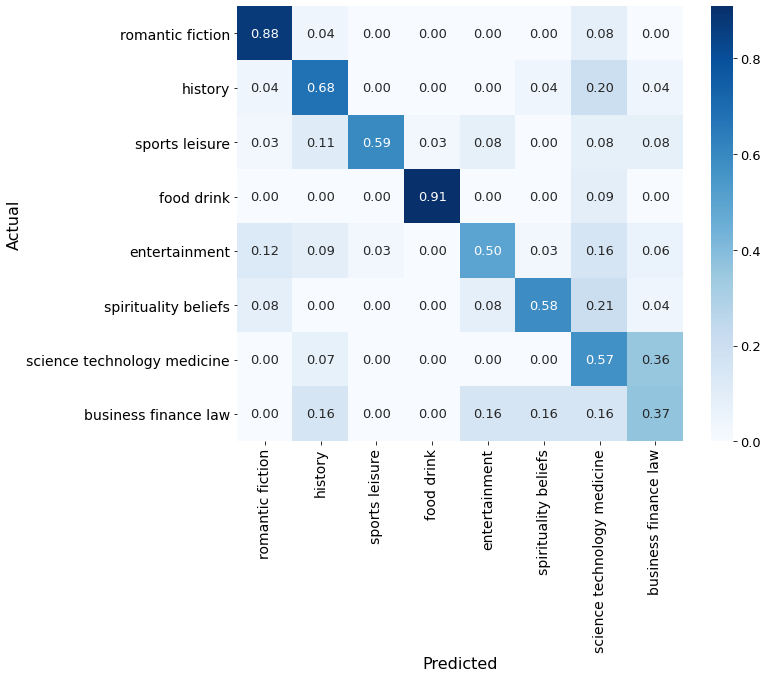

In [206]:
#################### c. Confusion matrix ####################

################################################
# Change to calling the function created above #
# class_matrix(true,pred,labels)               ~
################################################

y_true = validation_labels.numpy().argmax(axis=1)
y_pred = y_pred#.argmax(axis=1)

labels = ['romantic fiction',
          'history',
          'sports leisure',
          'food drink',
          'entertainment',
          'spirituality beliefs',
          'science technology medicine',
          'business finance law']

cm = confusion_matrix(y_true, y_pred)
# Convert nominal values into percentages (of class)
cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams.update({'font.size': 13})
sns.heatmap(cmp, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', size=16)
plt.xlabel('Predicted', size=16)
plt.show(block=False)

## Z. Code carpark

In [ ]:
#!pip install tensorboard
#!pip show tensorboard
#python C:\Users\jmd05\Anaconda3\Lib\site-packages\tensorboard\main.py --logdir=r'C:\Users\jmd05\Anaconda3\Lib\site-packages\tensorboard\logs\fit'

In [ ]:
# This automatically deletes the log directory

#import shutil
#shutil.rmtree('log_dir', ignore_errors=True)

In [ ]:
#valid['Subject'].value_counts(dropna=False)